In [1]:
import numpy as np
import matplotlib.pyplot as plt

First let's define the ellipses:

In [2]:
ell_a = 3   # Outer ellipse semi-major axis
ell_b = 1   # Outer ellipse semi-minor axis
ell_k = 0.5 # Ratio of inner ellipse to outer ellipse

The polar form of the ellipse is given by:

$$r(\theta) = \frac{a b}{\sqrt{b^2 \cos^2 \theta + a^2 \sin^2 \theta}}$$

In [3]:
def EllipseRadius(a, b, angle):
    return a * b / np.sqrt((b * np.cos(angle)) ** 2 + (a * np.sin(angle)) ** 2)

Let's use this to draw the two ellipses.

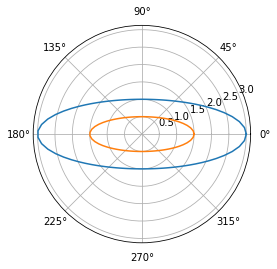

In [4]:
angles = np.linspace(0, np.deg2rad(360), 100)

rs = EllipseRadius(ell_a, ell_b, angles)
plt.polar(angles, rs)

rs = EllipseRadius(ell_k*ell_a, ell_k*ell_b, angles)
plt.polar(angles, rs)

That looks about right. Now let's calculate the area between the two ellipses. The area of an ellipse is given by:

$$A = \pi a b$$

In [5]:
def EllipseArea(a, b):
    return np.pi * a * b

area_outer = EllipseArea(ell_a, ell_b)
area_inner = EllipseArea(ell_k*ell_a, ell_k*ell_b)
area_annulus = area_outer - area_inner

print(f'Outer ellipse area = {area_outer}')
print(f'Inner ellipse area = {area_inner}')
print(f'Annulus area = {area_annulus}')

Outer ellipse area = 9.42477796076938
Inner ellipse area = 2.356194490192345
Annulus area = 7.0685834705770345


We're going to choose a random value within the annulus area, then figure out how far we have to integrate with respect to the angle to get that area. To do this, we will need to solve the following integral:

$$
A = \int_{0}^{x} \int_{0}^{r(\theta)} r \,dr \,d\theta = \int_{0}^{x} \frac{r(\theta)^2}{2} \,d\theta = \frac{a^2 b^2}{2} \int_{0}^{x} \frac{\,d\theta}{b^2 \cos^2 \theta + a^2 \sin^2 \theta}
$$

We rewrite the area integral as:

$$
A = \frac{a^2 b^2}{2} \int_{0}^{x} \frac{\sec^2 \theta \,d\theta}{b^2 + a^2 \tan^2 \theta}
$$

Then we make the following change of variables:

$$
a \tan \theta = b \tan \phi \implies a \sec^2 \theta \,d\theta = b \sec^2 \phi \,d\phi
$$

This gives:

$$
A = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \sec^2 \phi \,d\phi}{b^2 (1 + \tan^2 \phi)}
$$

with:

$$
y = \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

Using the Pythagorean identity $1 + tan^2 \phi = \sec^2 \phi$, we get:

$$
A = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \sec^2 \phi \,d\phi}{b^2 \sec^2 \phi} = \frac{a^2 b^2}{2} \int_{0}^{y} \frac{(b/a) \,d\phi}{b^2} = \frac{a b}{2} \int_{0}^{y} \,d\phi
$$

Substituting the expression for $y$, we get:

$$
A = \frac{a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

To get the area of the annulus, we take:

$$
A_{outer} - A_{inner} = \frac{a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right) - \frac{k^2 a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right) = \frac{a b - k^2 a b}{2} \tan^{-1} \left( {\frac{a}{b} \tan x} \right)
$$

Finally, we solve for x:

$$
x = \tan^{-1} \left( \frac{b}{a} \tan \left( \frac{2 (A_{outer} - A_{inner})}{a b - k^2 a b} \right) \right)
$$

Let's try this out:

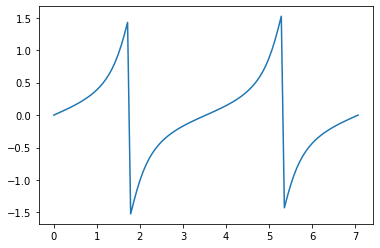

In [6]:
def AnnulusAngle(a, b, k, area):
    return np.arctan(b / a * np.tan((2 * area) / (a * b * (1 - k**2))))

xs = np.linspace(0, area_annulus, 100)
ys = AnnulusAngle(ell_a, ell_b, ell_k, xs)

plt.plot(xs, ys)

This is really close, but we're running into an issue because if the ambiguity of $\tan^{-1}(u)$.

First, we see that the total area of the annulus is $\pi ab (1-k^2)$. So the expression for $x$ becomes:

$$
x = \tan^{-1} \left( \frac{b}{a} \tan \left( 2 \pi \frac{A_{sample}}{A_{total}} \right) \right)
$$

This suggests that we can reorganize the expression to retain information about what quadrant the angle represents:

$$
x = \tan^{-1} \left( \frac{b}{a} \frac{ \sin \alpha}{ \cos \alpha} \right)
$$

with:

$$
\alpha = 2 \pi \frac{A_{sample}}{A_{total}}
$$

Going back to the code:

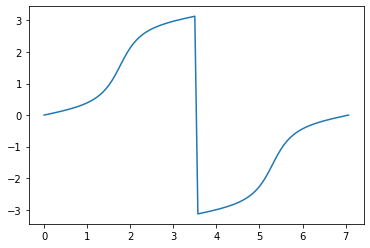

In [7]:
def AnnulusAngle(a, b, k, area):
    area_total = np.pi * a * b * (1 - k**2)
    alpha = 2 * np.pi * area / area_total
    return np.arctan2(b / a * np.sin(alpha), np.cos(alpha))

xs = np.linspace(0, area_annulus, 100)
ys = AnnulusAngle(ell_a, ell_b, ell_k, xs)

plt.plot(xs, ys)

That's it! At this point, we can take a random portion of the total area and find out what angle it corresponds with. The last step is to choose a random radius at that angle.

The area of an angular element with radius $x$ is be given by:

$$
A = \int_{0}^{x} r dr = \frac{x^2}{2}
$$

We can also solve this for $x$ to get the inverse relation:

$$
x = \sqrt{2 A}
$$

Finally, we can put all this together to get a random point within the annulus:

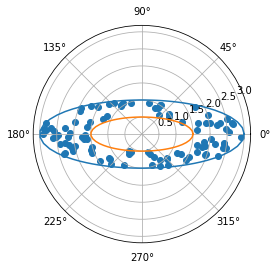

In [8]:
def RandomPoint(a, b, k):
    # Total area of the annulus
    area_total = np.pi * a * b * (1 - k**2)
    
    # Random sample from within that area
    area_sample = np.random.rand() * area_total
    
    # Figure out what angle that corresponds with
    theta = AnnulusAngle(a, b, k, area_sample)
    
    # Get the inner and outer radius of the annulus at that angle
    r_outer = EllipseRadius(a, b, theta)
    r_inner = EllipseRadius(k*a, k*b, theta)

    # Get area element corresponding to these two
    a_outer = r_outer**2 / 2
    a_inner = r_inner**2 / 2
    
    # Get a random area in that range
    a_random = a_inner + np.random.rand() * (a_outer - a_inner)
    
    # Finally, get the radius corresponding with that area
    radius = np.sqrt(2 * a_random)
    
    return (theta, radius)

rs = []
angles = []

for _ in range(100):
    theta, radius = RandomPoint(ell_a, ell_b, ell_k)
    rs.append(radius)
    angles.append(theta)

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.scatter(angles, rs)

angles = np.linspace(0, np.deg2rad(360), 100)

rs = EllipseRadius(ell_a, ell_b, angles)
ax.plot(angles, rs)

rs = EllipseRadius(ell_k*ell_a, ell_k*ell_b, angles)
ax.plot(angles, rs)